# Separating Capacity and Utility 

## Overview 

The capacity and utility features are highly correlated (see below). This can affect overall model performance and feature importances.

To understand the extent of this effect we fit separate models to capacity and utility features, and compare performance.


- Capacity features: 111 calls offered, Ambulance answered, GP appointments available
- Utility features: 111 calls answered, Ambulance made

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_new.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) 
               if '/' in c else c for c in dta.columns]

In [5]:
dta.ccg.unique().shape

(73,)

## Feature correlations 

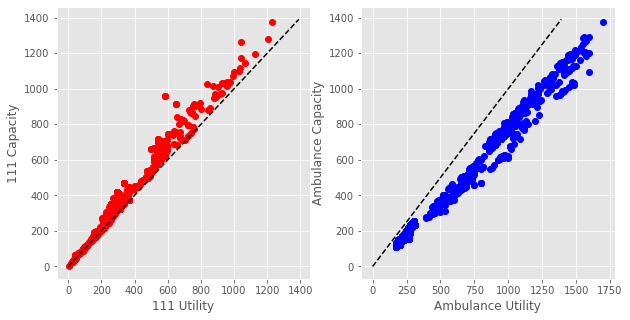

In [6]:
fig,ax_list = plt.subplots(1,2, figsize = (10,5))

xx = np.arange(0,140)*10

ax = ax_list[0]

ax.plot(dta['111_111_answered'].values, dta['111_111_offered'].values, 'ro')
ax.set_xlabel('111 Utility')
ax.set_ylabel('111 Capacity')
ax.plot(xx,xx, 'k--')

ax = ax_list[1]

ax.plot(dta['amb_sys_made'].values, dta['amb_sys_answered'].values, 'bo')
ax.set_xlabel('Ambulance Utility')
ax.set_ylabel('Ambulance Capacity')
ax.plot(xx,xx,'k--')

plt.show()

## Add random feature

In [7]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [8]:
dta.shape

(1465, 14)

## Fitting function 

In [9]:
def fit_model(dta, model, features):
    
    
    y = dta['ae_attendances_attendances']
    X = dta[features]
    
    #cross validate to get errors on performance and coefficients
    cv_model = cross_validate(model, X,y, 
                            cv=RepeatedKFold(n_splits=5, n_repeats=5,
                                             random_state=0),
                            return_estimator=True, 
                              return_train_score=True, n_jobs=2)
    
    clf = model.fit(X, y)

    
    return cv_model

## Utility Model 

In [10]:
features = ['111_111_answered', 'amb_sys_made', 'rand1']

### Linear Regression 

In [11]:
model = LinearRegression()

results = fit_model(dta,model,features)

#### Performance 

In [12]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

test_score  train_score
count   25.000000    25.000000
mean     0.088987     0.095958
std      0.019748     0.005173
min      0.048798     0.087471
25%      0.078996     0.092178
50%      0.081917     0.097625
75%      0.098685     0.099210
max      0.127353     0.108243

#### Coefficients 

In [13]:
coefs = pd.DataFrame(
   [model.coef_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

111_111_answered  amb_sys_made      rand1
count         25.000000     25.000000  25.000000
mean           0.326815     -0.152859  33.553221
std            0.019739      0.006087  12.074646
min            0.287791     -0.164263  16.134779
25%            0.314448     -0.157228  22.961364
50%            0.328274     -0.152665  35.276867
75%            0.340023     -0.149892  40.139995
max            0.379046     -0.137929  56.286215

### Random Forest 

In [14]:
model = RandomForestRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [15]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

test_score  train_score
count   25.000000    25.000000
mean     0.182760     0.887017
std      0.074938     0.003997
min      0.001584     0.878527
25%      0.139318     0.883952
50%      0.176371     0.887288
75%      0.219245     0.889623
max      0.311438     0.894594

#### Coefficients 

In [16]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

111_111_answered  amb_sys_made      rand1
count         25.000000     25.000000  25.000000
mean           0.207704      0.427467   0.364829
std            0.005822      0.006786   0.009722
min            0.195950      0.416397   0.347982
25%            0.203508      0.422391   0.356999
50%            0.208517      0.427979   0.365291
75%            0.210326      0.432412   0.369665
max            0.220490      0.439914   0.385886

### Gradient Boosted Trees 

In [17]:
model = GradientBoostingRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [18]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

test_score  train_score
count   25.000000    25.000000
mean     0.319724     0.496186
std      0.035518     0.009335
min      0.234387     0.481747
25%      0.300335     0.490776
50%      0.331010     0.494394
75%      0.346415     0.499322
max      0.364340     0.516133

#### Coefficients 

In [19]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

111_111_answered  amb_sys_made      rand1
count         25.000000     25.000000  25.000000
mean           0.207616      0.652034   0.140351
std            0.009749      0.010949   0.012934
min            0.191342      0.621564   0.111741
25%            0.198922      0.644237   0.132337
50%            0.210977      0.652832   0.137158
75%            0.216783      0.661093   0.147722
max            0.223436      0.668112   0.161653

### Summary 

Linear regression performs poorly, with an $R^2$ < 0.1

Random Forest overfits to the training data, and the random variable is comparatively important

Gradient boosted trees performs best and does not overfit. The random variable is ranked lowest.

## Capacity Model 

In [20]:
features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

### Linear Regression 

In [21]:
model = LinearRegression()

results = fit_model(dta,model,features)

#### Performance 

In [22]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

test_score  train_score
count   25.000000    25.000000
mean     0.104485     0.112303
std      0.021369     0.005553
min      0.064282     0.102830
25%      0.091363     0.108904
50%      0.098609     0.113295
75%      0.118014     0.115696
max      0.142532     0.125342

#### Coefficients 

In [23]:
coefs = pd.DataFrame(
   [model.coef_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

gp_appt_available  111_111_offered  amb_sys_answered      rand1
count          25.000000        25.000000         25.000000  25.000000
mean            0.014926         0.406422         -0.131261  28.604220
std             0.004327         0.013028          0.006844  11.985975
min             0.004248         0.372576         -0.143010  10.642999
25%             0.011283         0.399254         -0.134870  16.718126
50%             0.015775         0.408695         -0.132449  30.552794
75%             0.016698         0.414500         -0.127081  36.331556
max             0.022426         0.429938         -0.116957  53.013319

### Random Forest 

In [24]:
model = RandomForestRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [25]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

test_score  train_score
count   25.000000    25.000000
mean     0.367865     0.911295
std      0.052543     0.003579
min      0.242514     0.906006
25%      0.339958     0.909173
50%      0.379549     0.910843
75%      0.401601     0.912195
max      0.453416     0.918647

#### Coefficients 

In [26]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

gp_appt_available  111_111_offered  amb_sys_answered      rand1
count          25.000000        25.000000         25.000000  25.000000
mean            0.252558         0.240127          0.342297   0.165018
std             0.007858         0.022521          0.023092   0.006136
min             0.237367         0.192556          0.300921   0.151654
25%             0.247977         0.227112          0.329479   0.159818
50%             0.253531         0.240836          0.333854   0.165848
75%             0.259342         0.253717          0.351385   0.169550
max             0.268293         0.286385          0.383652   0.173943

### Gradient Boosted Trees 

In [27]:
model = GradientBoostingRegressor()

results = fit_model(dta,model,features)

#### Performance 

In [28]:
res=pd.DataFrame()
res['test_score'] = results['test_score']
res['train_score'] = results['train_score']

res.describe()

test_score  train_score
count   25.000000    25.000000
mean     0.405713     0.579198
std      0.034548     0.010241
min      0.337770     0.563322
25%      0.383794     0.571524
50%      0.401611     0.580027
75%      0.424398     0.586004
max      0.477016     0.596500

#### Coefficients 

In [29]:
coefs = pd.DataFrame(
   [model.feature_importances_
    for model in results['estimator']],
   columns=features
)

coefs.describe()

gp_appt_available  111_111_offered  amb_sys_answered      rand1
count          25.000000        25.000000         25.000000  25.000000
mean            0.167937         0.286532          0.490266   0.055265
std             0.019147         0.061529          0.060741   0.007001
min             0.132798         0.171415          0.406941   0.044187
25%             0.157221         0.232240          0.444097   0.050248
50%             0.167326         0.308844          0.470353   0.056020
75%             0.176296         0.335143          0.538904   0.061953
max             0.201599         0.362596          0.607708   0.067469

### Summary 

Linear regression again performs poorly.

Random Forest overfits to the training data, but the random variable is ranked lowest.

Gradient boosted trees performs best and does not overfit. The random variable is ranked lowest.